# Optically-dark short GRBs

## Imports/loading/setup

In [2]:
%load_ext autoreload
%autoreload 2

In [74]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns

from astropy.io import votable, ascii
from scipy import interpolate, stats

from code.utilities import custom_iter, split_filters, new_since_Fong
from code.xrt import XRT_lightcurve, get_photonIndex
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray
from code.fluxtools import effective_wavelength, lightcurve, simulate_spectrum

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"
UVOT_conversions = {'V': -0.01, 'B': -0.13, 'U': 1.02, 'UVW1': 1.51, 'UVM2': 1.69, 'UVW2': 1.73, 'White': 0.8}

In [150]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
for grb in swift[swift["TriggerNumber"].apply(pd.to_numeric,errors="coerce").isna()]["GRB"]: # non-Swift bursts
    bat_data = pd.read_html(f"https://swift.gsfc.nasa.gov/archive/grb_table/fullview/{grb}/")[0]
    T90 = bat_data.loc[bat_data[0]=="T90: c",1].values # get the T90 anyway, if it exists
    swift.loc[swift["GRB"]==grb,"BAT T90[sec]"] = pd.to_numeric(T90, errors="coerce")

In [198]:
valid = ['150424A', '150922A', '151221A', '170219A', '170708A', '170817A', '170825A',
         '180418A', '181121A', '181225A', '190121A', '190606A', '190831B', '050509B',
         '050724', '051103', '051105', '051114', '051211A', '051221', '060427B',
         '060429', '060502B', '070124', '070201', '070429B', '070714B', '070810B',
         '071112B', '080905', '080913', '081211B', '081216', '081223', '090531B',
         '090715A', '090916A', '090927A', '091117A', '091126B', '100213A', '100216A',
         '100816A', '110402A', '110802A', '120811B', '120830A', '140428B', '140604A',
         '150118C', '150906B', '150922A', '160111A', '160219A', '160406A', '160620A',
         '160709A', '160820A', '160822A', '160825A', '170127C', '170206A', '170219A',
         '170222A', '170403A', '170616A', '170708A', '170728B', '170805B', '170816A',
         '170817A', '170825A', '171103A', '180317A', '180529A', '181121A', '181225A',
         '190121A', '190206A', '190606A', '190831B', '200128B', '200219A', '200325A',
         '200327A', '200405B', '200521A', '200623B', '200716C', '200805A', '200815A',
         '200907A', '201214B', '201227A', '210205B', '210307B', '210424B', '210425A',
         '210506A'] # flagged from GCN Circulars

valid += ['130313A', '130822A', '130912A', '140903A', '141212A', '150120A', '150423A',
          '150831A', '160303A', '160408A', '160410A', '160411A', '160601A', '160612A',
          '160624A', '161001A', '170112A', '170127B', '170428A', '170524A', '180715A',
          '180718A', '180727A', '180805B', '181126A', '190427A', '191031D', '200623A',
          '201221D'] # Rastinejad, et al.

In [199]:
sGRBs = swift[(swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2) | swift["GRB"].isin(valid)].copy() # filter catalog for GRBs with a valid T90 that is <2s

### Data parsing and cleanup

In [200]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]','XRT InitialTemporalIndex':"α",
                      'XRTSpectral Index(Gamma)':'Γ','UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [201]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 270; error 398; error 577; error 618; error 666; error 695; error 777; error 910; error 1103; error 1105; error 1120; error 1186; error 1339; 

<ipython-input-201-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [202]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [203]:
#sGRBs.to_csv("./products/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],α,Γ,UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
13,210413B,1043009,1.088,NaN,NaN,NaN,185000,NaN,{'idx': 13},NaN,NaN,NaN,equal
19,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest
39,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 39},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal
48,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.2,brightest
52,201214B,1012872,NaN,28000,NaN,NaN,28000,NaN,{'idx': 52},Fermi (GBM),NaN,NaN,equal


### Legacy and new data imports

In [158]:
BetaXData = pd.read_csv("./data/BetaXData.csv", header=None, names=["GRB","Beta_X","Beta_X_pos","Beta_X_neg"])
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]
BetaXData["Beta_X"] *= -1

OpticalData = pd.read_csv("./data/OpticalData.csv", header=None, names=["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"])
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
OpticalData["Time"] *= 60*60

filters = pd.read_csv("./data/FilterInfo.csv", header=None, names=["Observatory","Instrument","Filter","Wavelength","Frequency"])
OpticalData = OpticalData.merge(filters,how="left",on=["Observatory","Instrument","Filter"])

XRayData = pd.read_csv("./data/XRayData.csv", header=None, names=["GRB","Time","Exposure","F_x","e_F_x"])

In [204]:
new_sGRBs = new_since_Fong(sGRBs) # Fong et al. (2015) has data up to March 2015, i.e. GRB 150301A

In [205]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],α,Γ,UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
13,210413B,1043009,1.088,NaN,NaN,NaN,185000,NaN,{'idx': 13},NaN,NaN,NaN,equal
19,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest
39,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 39},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal
48,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.2,brightest
52,201214B,1012872,NaN,28000,NaN,NaN,28000,NaN,{'idx': 52},Fermi (GBM),NaN,NaN,equal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,150831A,653838,1.15,83.44,-2.511,1.63580,88,V>19.8,"{'B': '20.4', 'U': '21.0', 'UVM2': '21.3', 'UV...","INTEGRAL, Konus-Wind",NaN,19.8,brightest
548,150728A,650617,0.83,70.2,-0.4,NaN,75,V>19.8,"{'B': '21.1', 'U': '21.0', 'UVM2': '20.2', 'UV...",NaN,NaN,19.8,brightest
557,150710A,648437,0.15,49.2,NaN,NaN,53,V>18.1,"{'B': '19.1', 'U': '20.0', 'UVM2': '18.2', 'UV...",Konus-Wind,NaN,18.1,brightest
576,150424A,638946,91,87.87,-1.121,1.98937,99,V>19.8,"{'B': '20.71', 'U': '20.13', 'UVM2': '19.91', ...","Keck I (10m), Konus-Wind, NOT, MPG (2.2m), GTC...",3,19.8,brightest


## X-ray

### Retrieve Swift XRT light curve and spectrum

In [69]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst,swift)
Gamma = get_BetaX(burst,swift)

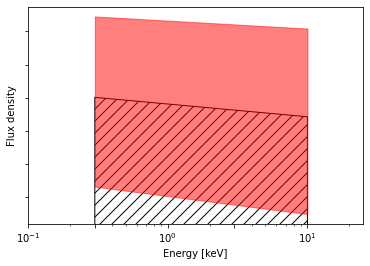

In [70]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")
plt.show()

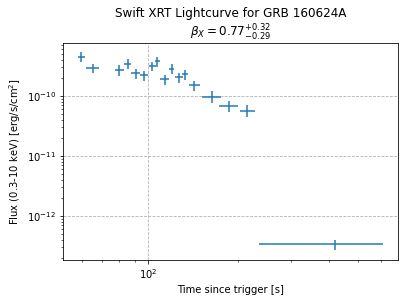

In [71]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gamma.minus,Gamma.plus))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.show()

In [207]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in sGRBs.index:
    GRB_ID = sGRBs.loc[i,"GRB"]
    print(GRB_ID,end=": ")
    try:
        Gamma = get_photonIndex(GRB_ID,swift)
        sGRBs.loc[i,"Beta_X"] = Gamma.value - 1
        sGRBs.loc[i,"Beta_X_neg"] = Gamma.minus
        sGRBs.loc[i,"Beta_X_pos"] = Gamma.plus
        print("index ✓",end=", ")
    except:
        print("index ✗",end=", ")
        
    try:
        fluxdata = XRT_lightcurve(GRB_ID,swift)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)
        print("lightcurve ✓")
    except:
        print("lightcurve ✗")

210413B: index ✗
210323A: index ✓, 210119A: index ✗
201221D: index ✓, 201214B: index ✗
201006A: index ✓, 200907B: index ✓, 200716C: index ✓, 200623A: index ✗
200522A: index ✓, 200411A: index ✓, 200405B: index ✗
200325A: index ✗
200219A: index ✓, 191031D: index ✓, 190627A: index ✓, 190610A: index ✗
190427A: index ✗
190326A: index ✗
181126A: index ✓, 181123B: index ✓, 180805B: index ✓, 180805A: index ✓, 180727A: index ✓, 180718A: index ✗
180715A: index ✗
180418A: index ✓, 180402A: index ✓, 180204A: index ✓, 171103A: index ✗
170728B: index ✓, 170728A: index ✓, 170524A: index ✓, 170428A: index ✓, 170325A: index ✗
170127B: index ✓, 170112A: index ✗
161104A: index ✓, 161001A: index ✓, 160927A: index ✓, 160821B: index ✓, 160726A: index ✗
160714A: index ✗
160709A: index ✗
160624A: index ✓, 160612A: index ✗
160601A: index ✓, 160525B: index ✓, 160411A: index ✓, 160410A: index ✓, 160408A: index ✓, 160303A: index ✓, 151229A: index ✓, 151228A: index ✗
151205B: index ✗
151127A: index ✓, 150831A: ind

### Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [208]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    if grb_id not in sGRBs["GRB"].values:
        continue
    beta = AsymmetricUncertainty(float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # 90% conf to 1-sigma
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))

    dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

<ipython-input-208-d6eb6bf3a868>:17: RuntimeWarning: invalid value encountered in double_scalars
  dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
<ipython-input-208-d6eb6bf3a868>:18: RuntimeWarning: invalid value encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
<ipython-input-208-d6eb6bf3a868>:18: RuntimeWarning: divide by zero encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))


In [209]:
for grb_id in XRayData["GRB"].unique(): # add David's old data in the same format
    GRB = grb_id[3:]
    lightcurve = XRayData.loc[XRayData["GRB"]==grb_id,:]
    if GRB not in xrt_data["GRB"].tolist():
        for i in lightcurve.index:
            t = lightcurve.loc[i,"Time"]
            tpos = tneg = lightcurve.loc[i,"Exposure"]/2
            flux = lightcurve.loc[i,"F_x"]/1000000 # uJy to Jy
            fluxpos = fluxneg = lightcurve.loc[i,"e_F_x"]/1000000
            newrow = dict(zip(xrt_data.columns,
                              [t,tpos,tneg,np.nan,np.nan,np.nan,GRB,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
            xrt_data = xrt_data.append(newrow, ignore_index=True)

## Optical

### Load new optical data

In [210]:
new_optical = pd.read_excel("./data/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)

rastinejad = pd.read_csv("./data/Rastinejad_Table1.csv")
for i in rastinejad.index:
    info = {}
    info["GRB"] = rastinejad.loc[i,"GRB"]
    if "/" in rastinejad.loc[i,"Telescope/Instrument"]:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[0]
        info["Instrument"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[1]
    else:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"]
    info["Filter"] = rastinejad.loc[i,"Filter"]
    info["Time (s)"] = float(rastinejad.loc[i,"dt [sec]"])
    if ">" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].replace(">",""))
        info["Mag error"] = "3-sigma"
    elif "+/-" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[0])
        info["Mag error"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[1])
    info["λ_eff"] = float(rastinejad.loc[i,"Wavelength"])
    info["Source"] = "Rastinejad"
    info["E(B-V)"] = float(rastinejad.loc[i,"E(B-V)"])
    new_optical = new_optical.append(info,ignore_index=True)

new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

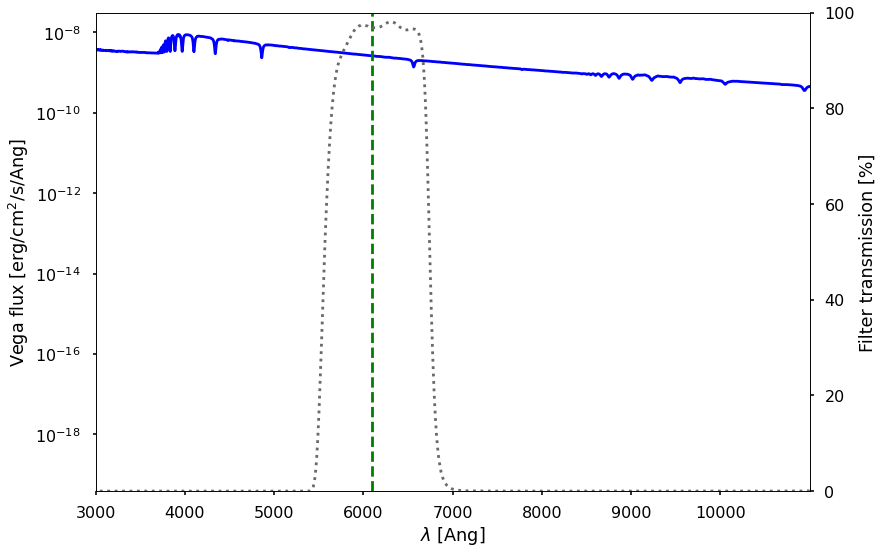

6100.363120460687

In [189]:
I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
rprime_filter.columns = ["Wavelength","Transmission"]
rprime_filter["Wavelength"] *= 10

effective_wavelength(rprime_filter,show_plot=True)

### Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [211]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

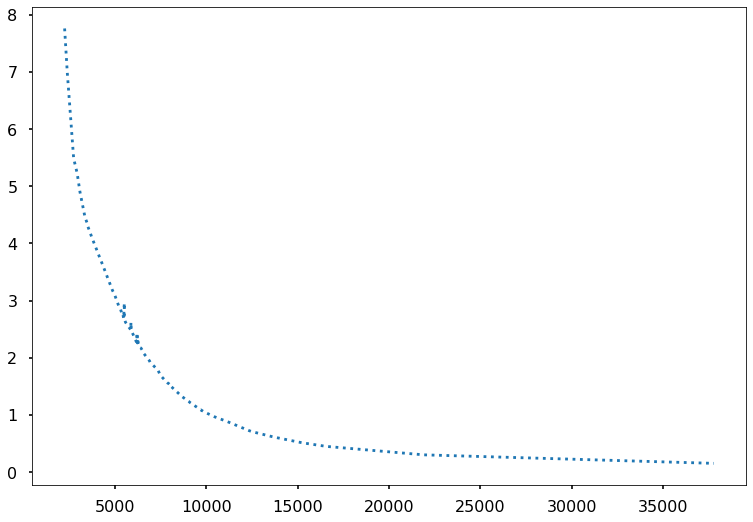

In [212]:
RbTable.sort_values(by="lambda_eff",inplace=True)
plt.plot(RbTable.lambda_eff, RbTable.R_b, ":")

In [213]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

### Converting optical magnitudes to spectral flux densities

In [214]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at f_nu = 3631 Jy

all_optical = new_optical.copy()

for i in OpticalData.index:
    GRB = OpticalData.loc[i,"GRB"]
    obs = OpticalData.loc[i,"Observatory"]
    inst = OpticalData.loc[i,"Instrument"]
    filt = OpticalData.loc[i,"Filter"]
    time = OpticalData.loc[i,"Time"]
    lambda_eff = OpticalData.loc[i,"Wavelength"]*10
    flux = OpticalData.loc[i,"F_o"]/1000000
    fluxpos = fluxneg = OpticalData.loc[i,"e_F_o"]/1000000
    newrow = dict(zip(all_optical.columns, [GRB,np.nan,obs,inst,filt,lambda_eff,time,np.nan,np.nan,"Fong",
                                            np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
    all_optical = all_optical.append(newrow, ignore_index=True)

## Compiling information

### Lightcurve comparisons

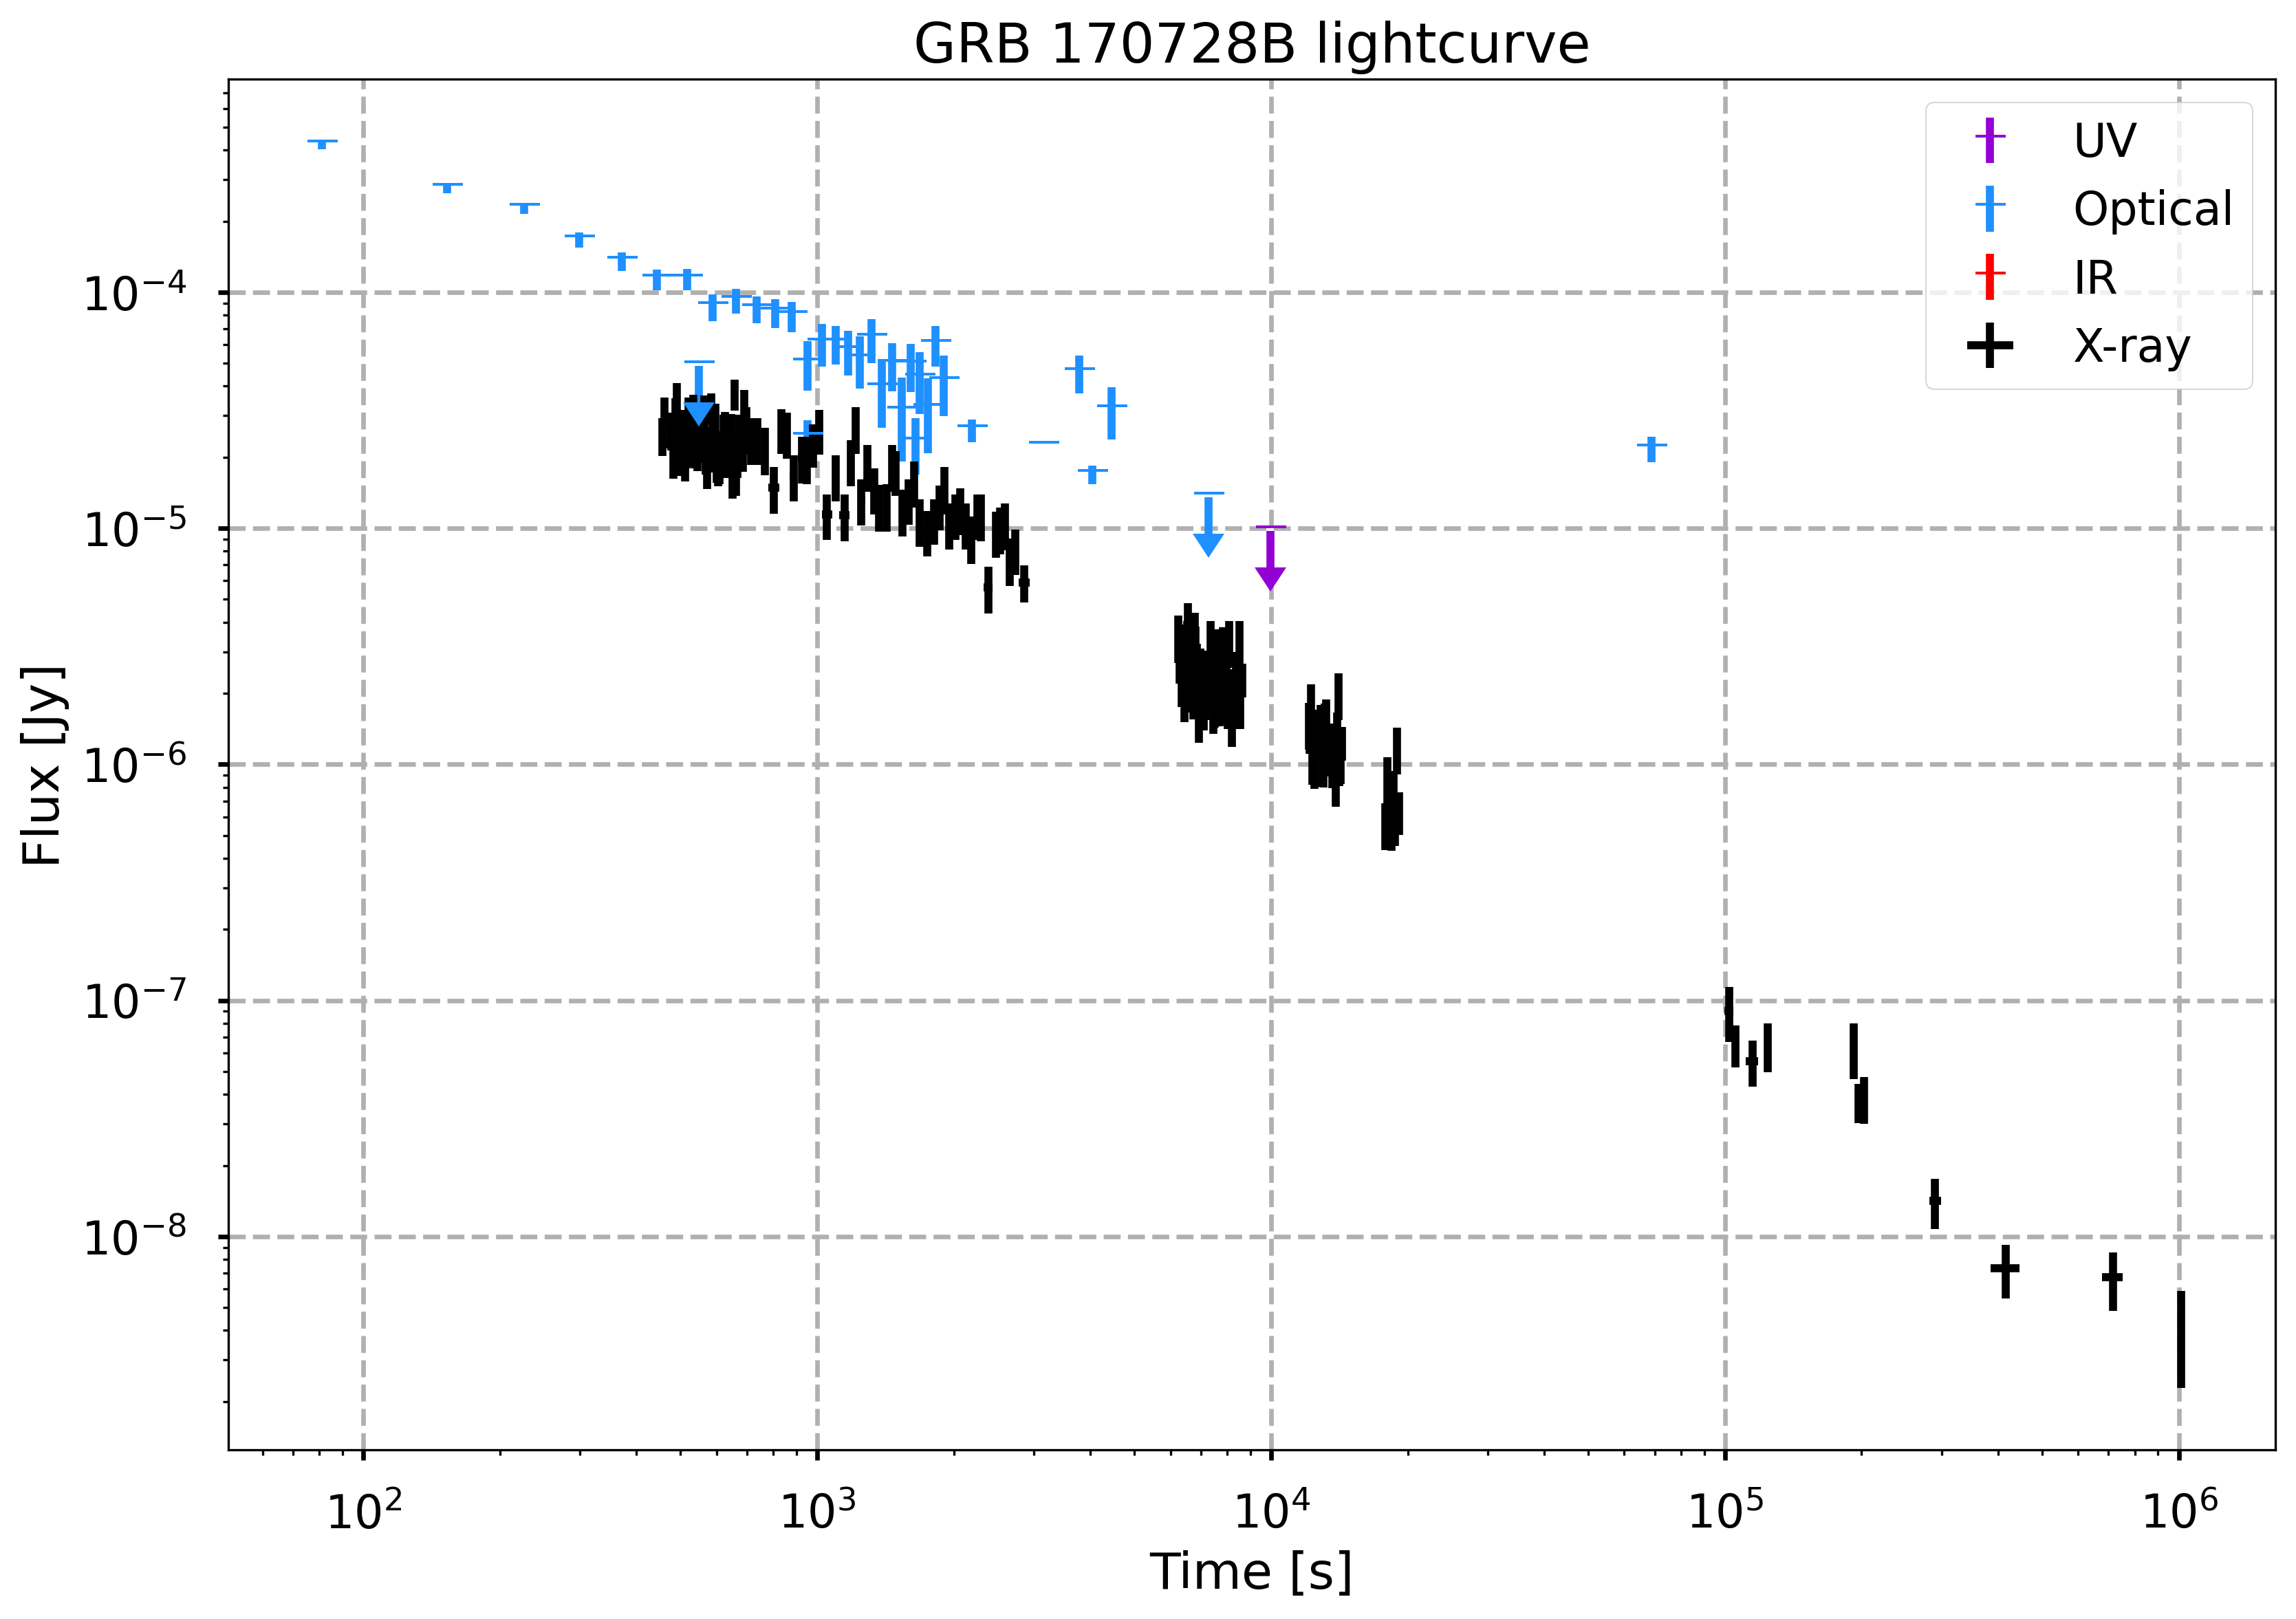

In [225]:
grb = "170728B"

fig, ax = plt.subplots(dpi=300)

subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()

subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
for band,info in bands.items():
    subsubset = subset[subset["band"]==band]
    neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
    pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
    ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

subset = xrt_data.loc[xrt_data["GRB"]==grb]
neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                      xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                      linestyle="",capthick=0,color="k",label="X-ray")

ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
ax.legend()
ax.grid(linestyle="--")

In [175]:
display(all_optical.sort_values(by=["GRB","Time (s)"], ascending=[False,True]))
display(xrt_data.sort_values(by=["GRB","Time"], ascending=[False,True]))

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,210413B,1043009,GECKO,LOAO,B,4380.74,185459.217,20.78,inf,GCN 29825,0.010,0.035828,"20.78 (+inf, -0.0)","1.829605792911923e-05 (+0.0, -inf)"
1,210413B,1043009,GECKO,LOAO,V,5445.79,186062.483,20.347,inf,GCN 29825,0.010,0.027438,"20.347 (+inf, -0.0)","2.7052138348248542e-05 (+0.0, -inf)"
2,210413B,1043009,GECKO,LOAO,R,6414.20,186666.417,19.594,inf,GCN 29825,0.010,0.021711,"19.594 (+inf, -0.0)","5.384069702947088e-05 (+0.0, -inf)"
3,210413B,1043009,GECKO,LOAO,I,7978.80,187263.350,19.293,inf,GCN 29825,0.010,0.015373,"19.293 (+inf, -0.0)","7.062776069562384e-05 (+0.0, -inf)"
21,210323A,1038247,Nanshan,NEXT,r,NaN,91.000,20.4,inf,GCN 29700,0.131,NaN,"20.4 (+inf, -0.0)","nan (+nan, -nan)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,050709,NaN,HST,ACS,F814W,8330.00,483840.000,NaN,NaN,Fong,NaN,NaN,NaN,3.4000000000000003e-07 ± 6e-09
826,050709,NaN,HST,ACS,F814W,8330.00,846720.000,NaN,NaN,Fong,NaN,NaN,NaN,1.7000000000000001e-07 ± 8e-09
827,050709,NaN,HST,ACS,F814W,8330.00,2998080.000,NaN,NaN,Fong,NaN,NaN,NaN,2e-08 ± 0.0
819,050509B,NaN,WIYN,OPTIC,r,6250.00,7560.000,NaN,NaN,Fong,NaN,NaN,NaN,7.5e-07 ± 0.0


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,90.691,1.772,-1.822,4.162478e-10,7.358302e-11,-7.358446e-11,210323A,2.723651204277404e-05 ± 4.904761274793357e-06
1,95.882,3.251,-3.419,2.102652e-10,3.838906e-11,-3.838998e-11,210323A,1.3758371770631024e-05 ± 2.5559588258795893e-06
2,101.302,2.183,-2.169,3.159472e-10,5.947158e-11,-5.947350e-11,210323A,2.0673502729757194e-05 ± 3.955634376822191e-06
3,106.615,2.334,-3.130,2.458731e-10,4.773577e-11,-4.773773e-11,210323A,1.6088318360241458e-05 ± 3.1719811063055207e-06
4,121.846,9.342,-5.702,2.036823e-10,4.575964e-11,-4.575964e-11,210323A,1.3327629993240761e-05 ± 3.0289737849755426e-06
...,...,...,...,...,...,...,...,...
2951,370000.000,1050.000,1050.000,NaN,NaN,NaN,050709,5.9e-09 ± 0.0
2952,1400000.000,3050.000,3050.000,NaN,NaN,NaN,050709,1.2999999999999999e-09 ± 6e-11
2953,1400000.000,6000.000,6000.000,NaN,NaN,NaN,050709,1.1000000000000001e-10 ± 2.0000000000000002e-11
2945,429.360,7249.446,-367.657,1.848813e-13,5.140629e-14,-5.140629e-14,050509B,1.1110465673132895e-08 ± 4.516770544781135e-09


### Match data points in time

In [176]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in all_optical.index: # for each optical data point
    t_o = all_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = all_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(all_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data[xrt_data["GRB"]==all_optical.loc[i_o,"GRB"]].index: # for each x-ray data point on this GRB
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if dt <= max_dt: # if time separation is allowable
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox.value):
                results = results.append({"GRB":all_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # if data points don't match
            pass

In [177]:
# get the previously retreived x-ray spectral indices for comparison

all_beta_x = pd.concat((sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]],BetaXData)) # table of all xray spectral indices
results = results.merge(all_beta_x,on="GRB",how="left") # match by GRB ID
results["B_x"] = [AsymmetricUncertainty(*results.loc[i,["Beta_X","Beta_X_pos","Beta_X_neg"]]) for i in results.index] # construct objects
results.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'],axis=1,inplace=True) # discard superfluous columns

# add flag columns for darkness by both methods
for i in results.index: # '<<' operator is overloaded for use with AsymmetricUncertainty class
    results.loc[i,"Jak_dark"] = (results.loc[i,"B_ox"] << 0.5)
    results.loc[i,"vdH_dark"] = (results.loc[i,"B_ox"] << results.loc[i,"B_x"]-0.5)

results.sort_values(by="GRB",ascending=False)

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
0,210323A,0.165115,4.816314e+14,6.905664110119469e-07 ± 1.272070338974806e-07,4.188080e+17,2.430646430740983e-09 ± 1.3082269147041803e-09,"0.8347169499806824 (+0.06743090287720507, -0.0...","0.72 (+0.2, -0.19)",False,False
12,210323A,0.053145,6.897727e+14,"0.00010697878691607805 (+0.0, -inf)",4.188080e+17,5.403372361761994e-07 ± 1.2319565677707346e-07,"0.8251447388859751 (+0.03553634305237809, -inf)","0.72 (+0.2, -0.19)",False,False
1,210323A,0.034537,4.734539e+14,2.906679197299785e-06 ± 4.0157257138910314e-07,4.188080e+17,1.9272753201566128e-08 ± 5.059993676717163e-09,"0.7392764117158406 (+0.043696197611704395, -0....","0.72 (+0.2, -0.19)",False,False
21,210323A,0.030235,4.881723e+14,3.2859900850819393e-06 ± 2.723857842828928e-07,4.188080e+17,1.9272753201566128e-08 ± 5.059993676717163e-09,"0.7607863341322437 (+0.04073028204811061, -0.0...","0.72 (+0.2, -0.19)",False,False
20,210323A,0.144464,1.116903e+15,"0.000288885003598624 (+0.0, -inf)",4.188080e+17,4.7009435119373687e-07 ± 1.0491056567996635e-07,"1.0833490900070264 (+0.037610434762944595, -inf)","0.72 (+0.2, -0.19)",False,False
...,...,...,...,...,...,...,...,...,...,...
345,050709,0.016301,4.576984e+14,9.000000000000001e-07 ± 5.0000000000000004e-08,4.188080e+17,1.5e-09 ± 0.0,0.9381096319868512 ± 0.008147221336809634,1.24 ± 0.35,False,False
348,050709,0.018519,4.626427e+14,1.17e-06 ± 2.6e-07,4.188080e+17,1.1000000000000001e-09 ± 2.0000000000000002e-11,1.02368256529566 ± 0.032749384671304727,1.24 ± 0.35,False,False
349,050709,0.018359,5.382270e+14,3.6e-07 ± 0.0,4.188080e+17,5.9e-09 ± 0.0,0.617578667886267 ± 0.0,1.24 ± 0.35,False,False
343,050709,0.012972,5.382270e+14,6.4e-07 ± 7e-08,4.188080e+17,1.5e-09 ± 0.0,0.9097349351781538 ± 0.016430351407324628,1.24 ± 0.35,False,False


### Determine darkness

In [178]:
dark = results.loc[results["Jak_dark"] | results["vdH_dark"],:].sort_values(by=["GRB","dt%"],ascending=[False,True])
for GRB in dark["GRB"].unique():
    print(GRB,dark["GRB"].tolist().count(GRB))

210323A 3
200411A 3
191031D 1
181123B 1
180727A 1
180204A 3
161001A 2
160927A 1
160821B 26
160624A 5
151229A 10
150831A 12
150423A 1
130912A 14
120804A 4
080919 1
080503 3
070714B 14
070707 2
060313 16
060121 56


In [102]:
# only accept the closest in time for each GRB
close_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    closest_time = working["dt%"].min()
    close_times.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)
    
darkest_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    darkest_beta = working["B_ox"].min()
    darkest_times.drop(working[working["B_ox"] != darkest_beta].index, axis=0, inplace=True)

### Compare spectral index distributions

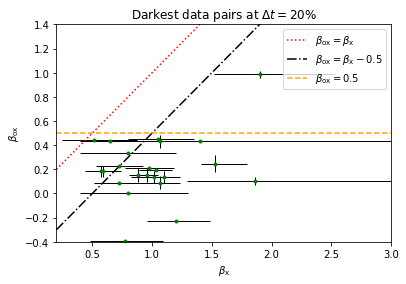

In [103]:
b_ox = [b.value for b in darkest_times["B_ox"]]
oxplus = [b.plus for b in darkest_times["B_ox"]]
oxminus = [b.minus for b in darkest_times["B_ox"]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [b.plus for b in darkest_times["B_x"]]
xminus = [b.minus for b in darkest_times["B_x"]]
bursts = [grb for grb in darkest_times["GRB"]]
plt.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],linestyle="",marker=".",
             mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
x = np.linspace(0.2,3,50)
y = np.linspace(-.4,1.4,50)
plt.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(.2,3)
plt.xlabel(r"$\beta_\mathrm{x}$")
plt.ylim(-.4,1.4)
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.title(f"Darkest data pairs at $\Delta t={int(100*max_dt)}\%$")
plt.legend()
plt.show()

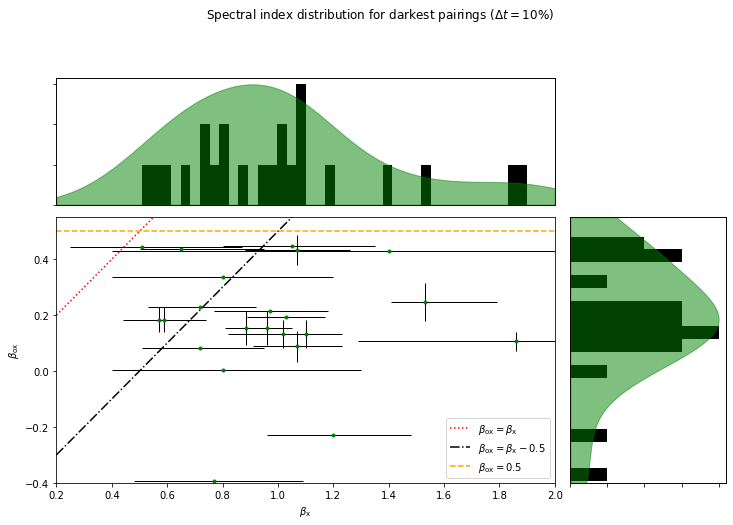

In [106]:
fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

x = np.linspace(0.2,2,100)
y = np.linspace(-.4,0.55,100)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],linestyle="",marker=".",
                 mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
ax_main.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.legend()

kde = stats.gaussian_kde(b_x)
density = kde.evaluate(x)
ax_kde_x = ax_top.twinx()
ax_kde_x.fill_between(x,density,color="green",alpha=.5)
ax_kde_x.set_ylim(0)
ax_kde_x.set_yticks([])
ax_top.hist(b_x,40,orientation='vertical', color="k")
ax_top.set_xticks([])
ax_top.set_xlim(ax_main.get_xlim())

kde = stats.gaussian_kde(b_ox)
density = kde.evaluate(y)
ax_kde_y = ax_right.twiny()
ax_kde_y.fill_betweenx(y,density,color="green",alpha=.5)
ax_kde_y.set_xlim(0)
ax_kde_y.set_xticks([])
ax_right.hist(b_ox, 30, orientation='horizontal', color="k")
ax_right.set_yticks([])
ax_right.set_ylim(ax_main.get_ylim())

fig.suptitle(r"Spectral index distribution for darkest pairings ($\Delta t=10$%)")

plt.show()

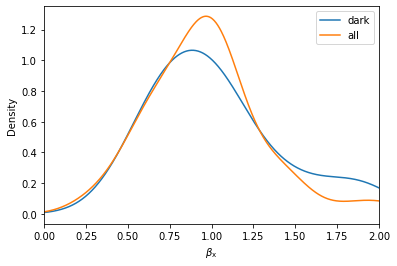

In [105]:
pd.Series([bx.value for bx in dark.drop_duplicates("GRB")["B_x"]]).plot.kde(label="dark")
pd.Series([bx.value for bx in results.drop_duplicates("GRB")["B_x"]]).plot.kde(label="all")
plt.xlim(0,2)
#plt.gca().set_yticklabels([])
plt.xlabel(r"$\beta_\mathrm{x}$")
plt.legend()
plt.show()

## Illustrative example plot

GRB                                                 160624A
dt%                                               0.0742895
nu_o                                            7.71532e+14
F_o                     2.2469077263974652e-05 (+0.0, -inf)
nu_x                                            4.18808e+17
F_x           6.43563651729827e-06 ± 1.4683568734923836e-06
B_ox        0.1985597727235074 (+0.03610621145682231, -inf)
B_x                                     0.77 (+0.32, -0.29)
Jak_dark                                               True
vdH_dark                                              False
Name: 206, dtype: object

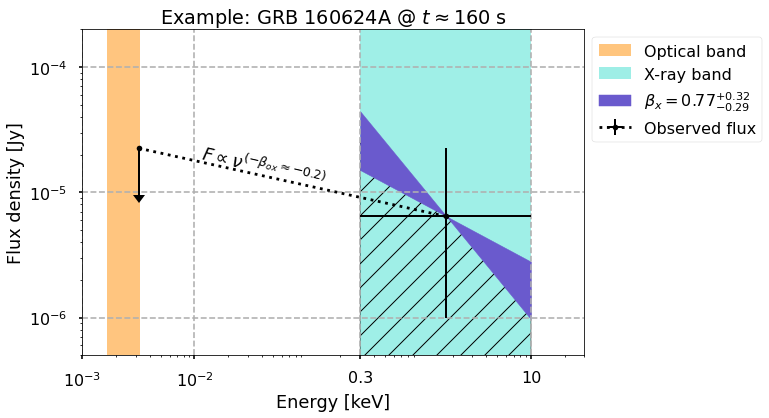

In [123]:
display(results[results["GRB"]=="160624A"].iloc[3,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
beta = results.loc[206,"B_x"]
E_o = results.loc[206,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[206,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[206,"F_o"]
F_x = results.loc[206,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A @ $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./products/160624A.png",bbox_inches="tight",dpi=300)

## Search samples for anomalies

In [83]:
Fong_Bx_GRBs = set(BetaXData.GRB.values)
Fong_xray_GRBs = set([grb[3:] for grb in XRayData.GRB.values])
xrt_obs_GRBs = set([grb for grb in xrt_obs.GRB.values if int(grb[:6])<150301])
Swift_table_GRBs = set([grb for grb in sGRBs.GRB.values if int(grb[:6])<150301])
spectrum_GRBs = set(sGRBs.loc[sGRBs["Beta_X"].notna(),"GRB"])
lightcurve_GRBs = set(xrt_data["GRB"].unique())

In [84]:
all_catalogs = set(['Fong beta x', 'Fong XRT', 'All XRT obs', 'Swift GRB table', 'XRT lightcurve repo', 'Spectrum info'])
anomalycount = 0
for datenum in range(50505,150301):
    code = str(datenum).zfill(6)
    memberships = []
    for elem in Fong_Bx_GRBs:
        if elem[:6] == code and "Fong beta x" not in memberships:
            memberships.append("Fong beta x")
    for elem in Fong_xray_GRBs:
        if elem[:6] == code and "Fong XRT" not in memberships:
            memberships.append("Fong XRT")
    for elem in xrt_obs_GRBs:
        if elem[:6] == code and "All XRT obs" not in memberships:
            memberships.append("All XRT obs")
    for elem in Swift_table_GRBs:
        if elem[:6] == code and "Swift GRB table" not in memberships:
            memberships.append("Swift GRB table")
    for elem in spectrum_GRBs:
        if elem[:6] == code and "Spectrum info" not in memberships:
            memberships.append("Spectrum info")
    for elem in lightcurve_GRBs:
        if elem[:6] == code and "XRT lightcurve repo" not in memberships:
            memberships.append("XRT lightcurve repo")

    if len(memberships)>0 and memberships != ["All XRT obs"] and len(memberships) != 6:
        missing = all_catalogs - set(memberships)
        anomalycount += 1
        print(code+"(x) is in",memberships,"\n\t\tbut missing from",missing)

050709(x) is in ['Fong beta x', 'Fong XRT', 'XRT lightcurve repo'] 
		but missing from {'Swift GRB table', 'Spectrum info', 'All XRT obs'}
050724(x) is in ['Fong beta x', 'Fong XRT', 'All XRT obs', 'XRT lightcurve repo'] 
		but missing from {'Swift GRB table', 'Spectrum info'}
050813(x) is in ['Fong beta x', 'Fong XRT', 'All XRT obs', 'Swift GRB table', 'XRT lightcurve repo'] 
		but missing from {'Spectrum info'}
050906(x) is in ['Fong XRT', 'Swift GRB table', 'XRT lightcurve repo'] 
		but missing from {'Fong beta x', 'Spectrum info', 'All XRT obs'}
050925(x) is in ['Fong XRT', 'Swift GRB table', 'XRT lightcurve repo'] 
		but missing from {'Fong beta x', 'Spectrum info', 'All XRT obs'}
051105(x) is in ['Swift GRB table'] 
		but missing from {'Fong XRT', 'Spectrum info', 'All XRT obs', 'XRT lightcurve repo', 'Fong beta x'}
060121(x) is in ['Fong beta x', 'Fong XRT', 'All XRT obs', 'XRT lightcurve repo'] 
		but missing from {'Swift GRB table', 'Spectrum info'}
061006(x) is in ['Fong beta